# VGG16 Final

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Constant Parameters
TRAIN_DIR = "../data/train/"
MODEL_DIR = "../models/"
VALIDATION_SPLIT = 0.2
IMAGE_HEIGHT = IMAGE_WIDTH = 224
BATCH_SIZE = 64
SEED = 1

# Training Parameters
NUM_EPOCHS = 20
STARTING_EPOCH = 20
OPTIMIZER = keras.optimizers.Adam()
LOSS_FN = keras.losses.CategoricalCrossentropy()

In [3]:
model_id = "vgg16_final_15epochs"              # Unique Identifier used for saving model
color_mode = "rgb"                             # "rgb", "rgba" or "grayscale"
image_depth = 3

In [4]:
# Model Architecture
def get_model(image_depth, num_classes):
    model = keras.models.Sequential()
    
    model.add(keras.applications.VGG16(include_top = False,
                                         pooling = "avg",
                                         input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, image_depth)))
    model.add(keras.layers.Dense(1024, activation = "relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(num_classes, activation = "softmax"))
    
    model.layers[0].trainable = False
    return model

In [5]:
# Data Augmentation Parameters
image_generator = ImageDataGenerator(
    validation_split = VALIDATION_SPLIT,
    rescale = 1./255,
    rotation_range = 45,
    horizontal_flip = True,
    zoom_range = 0.4
)

In [6]:
train_data_gen = image_generator.flow_from_directory(
    color_mode = color_mode,
    directory = TRAIN_DIR,
    batch_size = BATCH_SIZE,
    target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle = True,
    seed = SEED,
    class_mode = "categorical",
    subset = "training"
)

Found 84331 images belonging to 42 classes.


In [7]:
validation_data_gen = image_generator.flow_from_directory(
    color_mode = color_mode,
    directory = TRAIN_DIR,
    batch_size = BATCH_SIZE,
    target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode = "categorical",
    subset = "validation"
)

Found 21061 images belonging to 42 classes.


In [8]:
model = get_model(image_depth, train_data_gen.num_classes)

In [9]:
model.compile(
    optimizer = OPTIMIZER,
    loss = LOSS_FN,
    metrics = ["accuracy"]
)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 42)                43050     
Total params: 15,283,050
Trainable params: 568,362
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
history = model.fit(
    train_data_gen,
    epochs = NUM_EPOCHS,
    initial_epoch = STARTING_EPOCH,
    steps_per_epoch = train_data_gen.n // BATCH_SIZE,
    validation_data = validation_data_gen,
    callbacks = [
        keras.callbacks.CSVLogger(MODEL_DIR + "{}.csv".format(model_id)),
        keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                    mode = "max",
                                    patience = 10,
                                    verbose = 1,
                                    restore_best_weights = True),
        keras.callbacks.ModelCheckpoint(MODEL_DIR + "checkpoints/" + model_id + ".{epoch:03d}-{val_accuracy:.4f}",
                                      verbose = 1,
                                      save_weights_only = False,
                                      save_freq = "epoch",
                                      period = 5)
    ]
)

Epoch 1/20
1317/1317 [==============================] - 2027s 2s/step - loss: 2.5356 - accuracy: 0.3243 - val_loss: 2.1749 - val_accuracy: 0.4136
Epoch 2/20
1317/1317 [==============================] - 1800s 1s/step - loss: 2.1660 - accuracy: 0.4150 - val_loss: 2.0241 - val_accuracy: 0.4512
Epoch 3/20
1317/1317 [==============================] - 1819s 1s/step - loss: 2.0726 - accuracy: 0.4412 - val_loss: 1.9787 - val_accuracy: 0.4666
Epoch 4/20
1317/1317 [==============================] - 1798s 1s/step - loss: 2.0215 - accuracy: 0.4514 - val_loss: 1.9656 - val_accuracy: 0.4694
Epoch 5/20
1317/1317 [==============================] - ETA: 0s - loss: 1.9799 - accuracy: 0.4631
Epoch 00005: saving model to ../models/checkpoints/model.005-0.4782.h5
1317/1317 [==============================] - 1818s 1s/step - loss: 1.9799 - accuracy: 0.4631 - val_loss: 1.9151 - val_accuracy: 0.4782
Epoch 6/20
1317/1317 [==============================] - 1802s 1s/step - loss: 1.9534 - accuracy: 0.4681 - val_lo

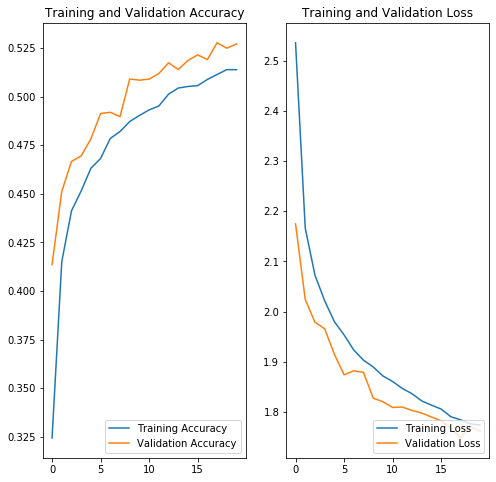

In [12]:
acc = history.history["accuracy"]
loss = history.history["loss"]
validation_acc = history.history["val_accuracy"]
validation_loss = history.history["val_loss"]

epochs_range = range(len(history.history["accuracy"]))

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = "Training Accuracy")
plt.plot(epochs_range, validation_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = "Training Loss")
plt.plot(epochs_range, validation_loss, label = "Validation Loss")
plt.legend(loc = "lower right")
plt.title("Training and Validation Loss")
plt.show()

In [13]:
model.save(MODEL_DIR + "{}".format(model_id), overwrite = False)